In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

In [13]:
# Load the Excel file
file_path = './Grupo_3.xlsx'

# Load the sheet names
xls = pd.ExcelFile(file_path)
print(xls.sheet_names)  # This will show the available sheet names

# Load each sheet into a separate DataFrame
dfSantaAna = pd.read_excel(xls, sheet_name=xls.sheet_names[0])
dfLaFloresta = pd.read_excel(xls, sheet_name=xls.sheet_names[1])

# Optional: Show the first few rows of each DataFrame
print(dfSantaAna.head())
print(dfLaFloresta.head())

['Santa Ana', 'La Floresta']
       Fecha        Ventas
0 2023-01-01  12622.120347
1 2023-01-02  19769.873469
2 2023-01-03  20177.671875
3 2023-01-04  17454.600891
4 2023-01-05  17672.242987
       Fecha        Ventas
0 2023-01-01  14767.536664
1 2023-01-02  13889.323232
2 2023-01-03  11491.085327
3 2023-01-04  18903.512075
4 2023-01-05  13703.219431


In [ ]:
# Función para graficar la ECDF de las ventas por mes
def plot_ecdf_por_mes(df, tienda):
    meses = df['mes'].unique()
    meses = sorted(meses)
    
    plt.figure(figsize=(15, 10))
    for i, mes in enumerate(meses, 1):
        ventas_mes = df[df['mes'] == mes]['Ventas'].dropna()
        x = np.sort(ventas_mes)
        y = np.arange(1, len(x)+1) / len(x)
        
        plt.subplot(3, 4, i)
        #plt.step(x, y, where='post')
        sns.ecdfplot(ventas_mes)
        plt.title(f'{tienda} - Mes {mes}')
        plt.xlabel('Ventas')
        plt.ylabel('F(x)')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


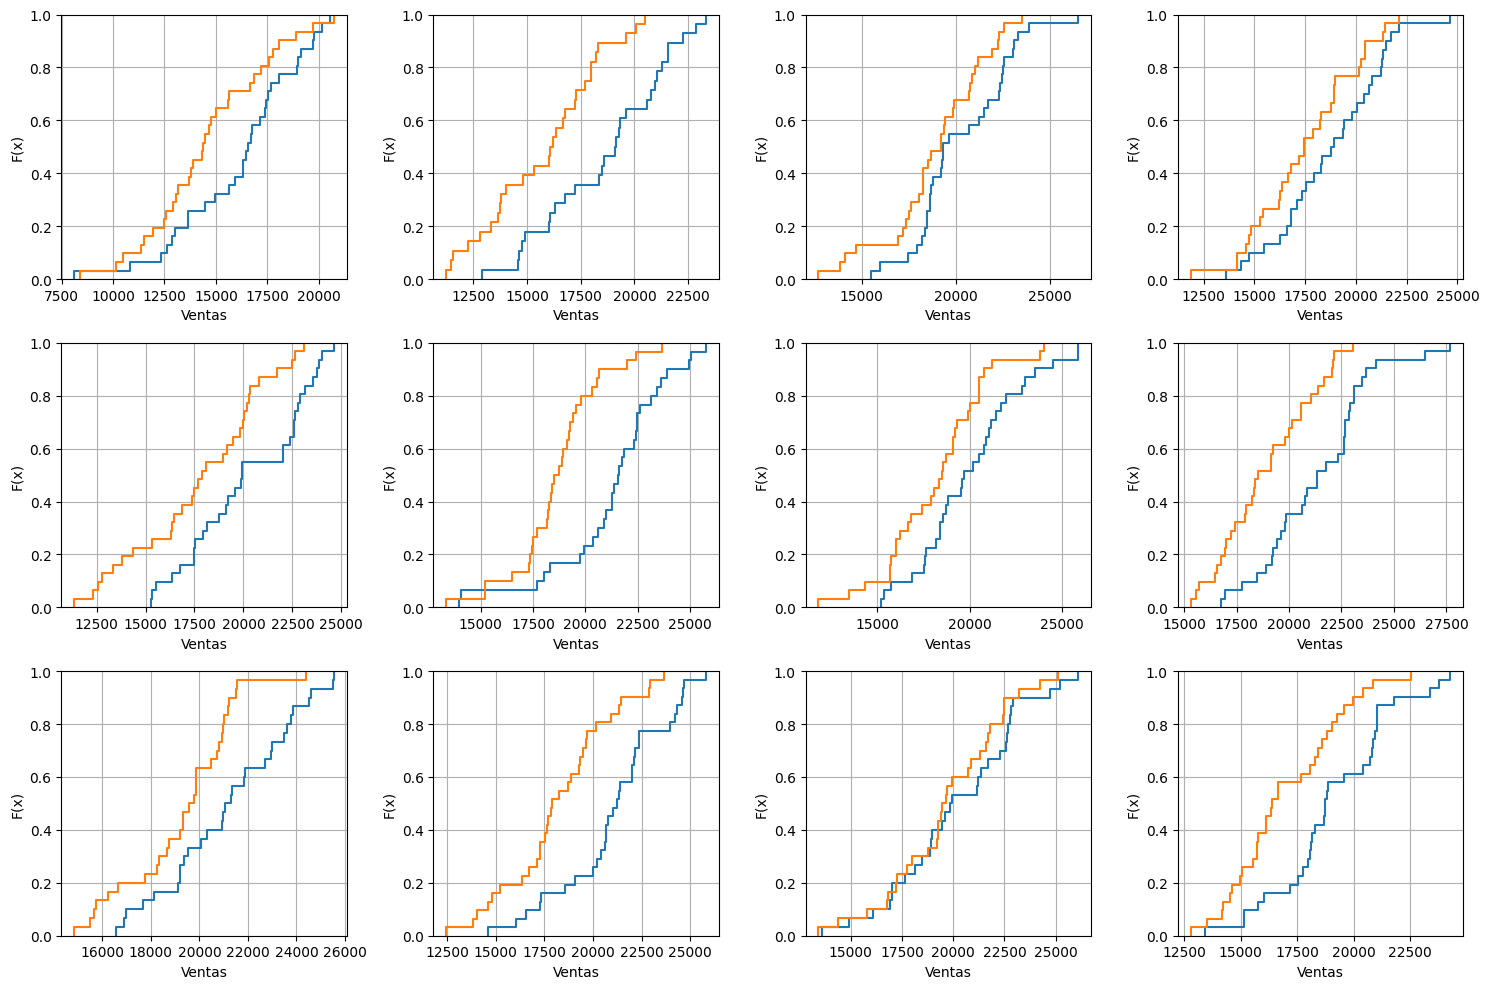

In [46]:
meses = dfSantaAna['mes'].unique()
meses = sorted(meses)
    
plt.figure(figsize=(15, 10))
for i, mes in enumerate(meses, 1):
    ventas_mes_santaAna = dfSantaAna[dfSantaAna['mes'] == mes]['Ventas'].dropna()
    ventas_mes_LaFloresta = dfLaFloresta[dfLaFloresta['mes'] == mes]['Ventas'].dropna()
    x = np.sort(ventas_mes_santaAna)
    y = np.arange(1, len(x)+1) / len(x)
    
    plt.subplot(3, 4, i)
    #plt.step(x, y, where='post')
    sns.ecdfplot(ventas_mes_santaAna)
    sns.ecdfplot(ventas_mes_LaFloresta)
    #plt.title(f'{tienda} - Mes {mes}')
    plt.xlabel('Ventas')
    plt.ylabel('F(x)')
    plt.grid(True)

plt.tight_layout()
plt.show()

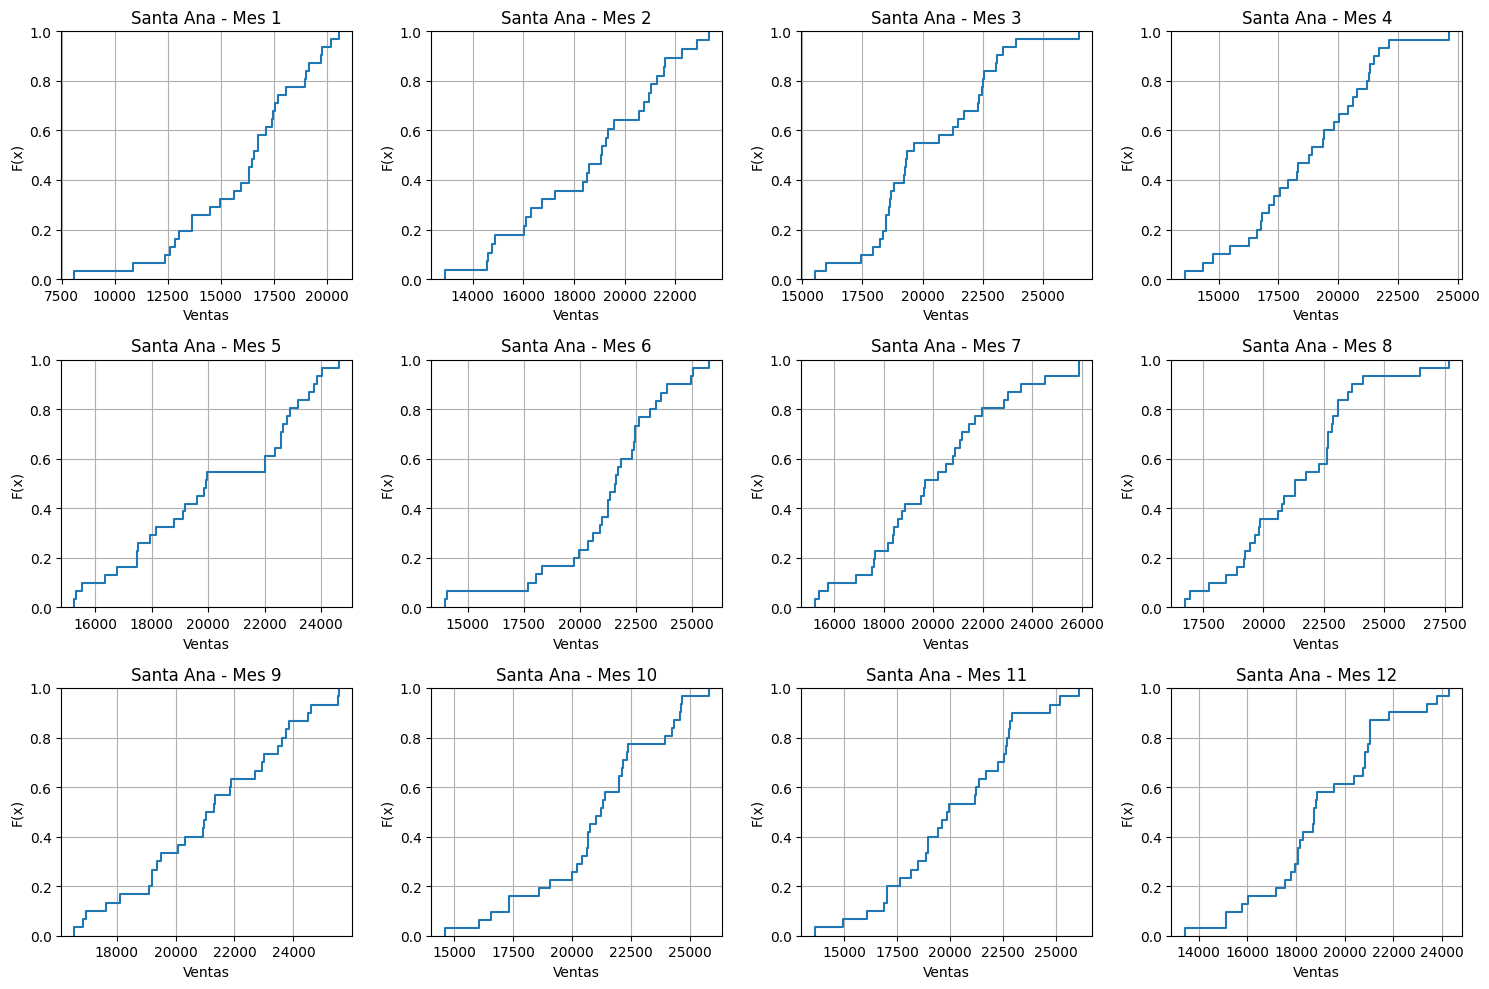

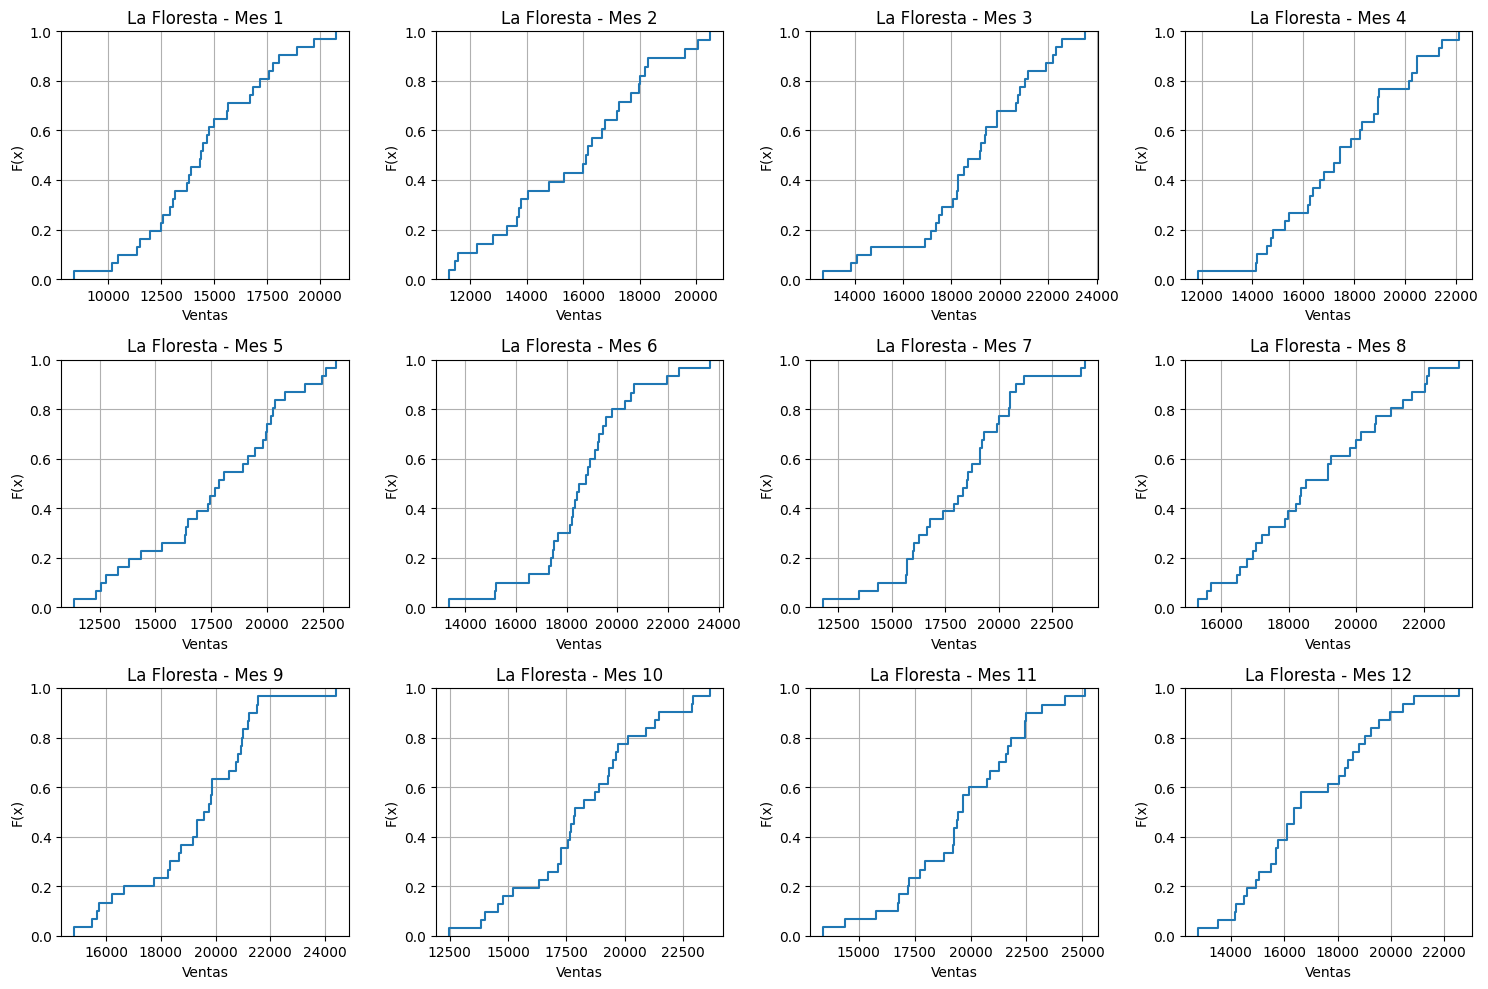

In [41]:
plot_ecdf_por_mes(dfSantaAna, 'Santa Ana')
plot_ecdf_por_mes(dfLaFloresta, 'La Floresta')  

In [36]:
def plot_kde_por_mes(df, tienda):
    meses = df['mes'].unique()
    meses = sorted(meses)

    plt.figure(figsize=(15, 10))
    for i, mes in enumerate(meses, 1):
        ventas_mes = df[df['mes'] == mes]['Ventas'].dropna()
        
        plt.subplot(3, 4, i)
        sns.kdeplot(ventas_mes, fill=True)
        plt.title(f'{tienda} - Mes {mes}')
        plt.xlabel('Ventas')
        plt.ylabel('Densidad')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

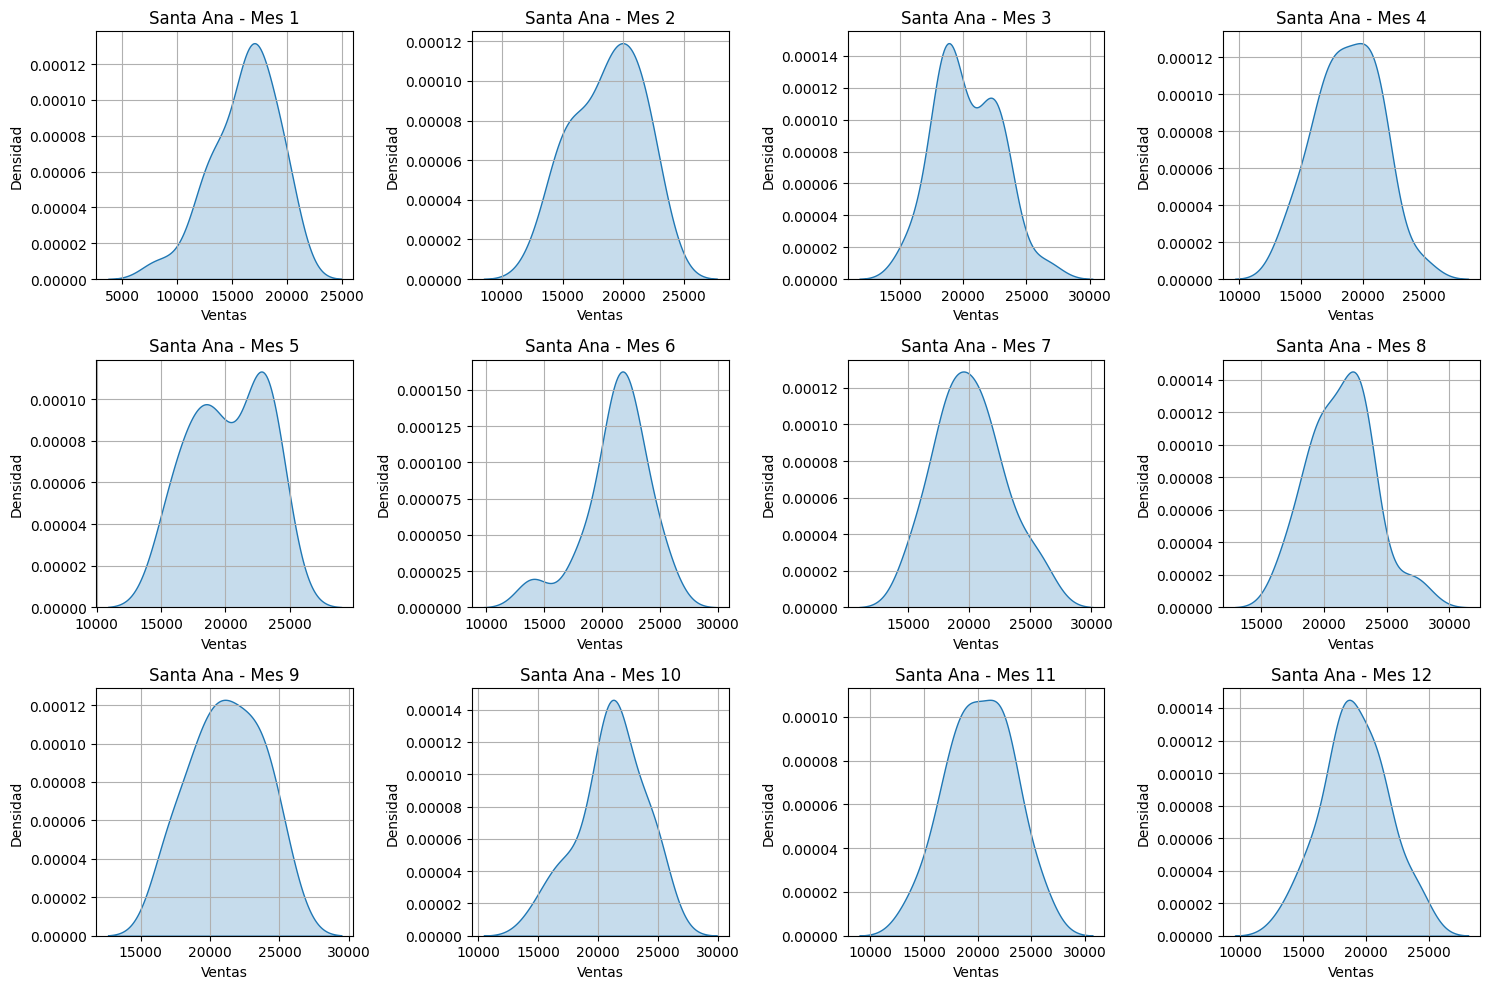

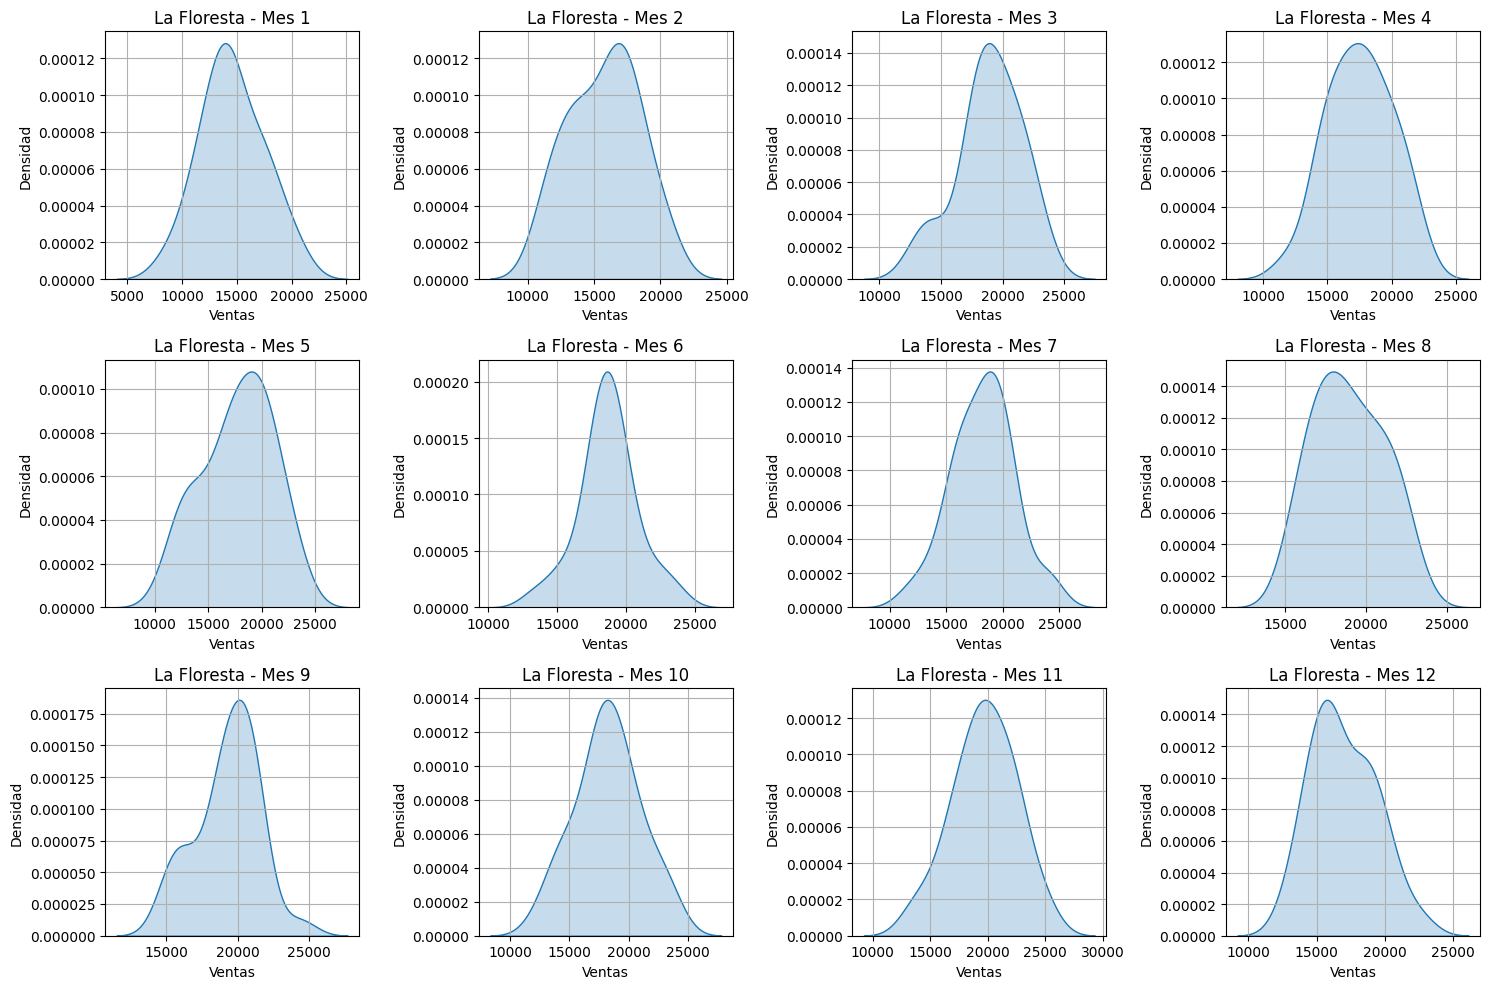

In [38]:
plot_kde_por_mes(dfSantaAna, 'Santa Ana')
plot_kde_por_mes(dfLaFloresta, 'La Floresta')  

In [42]:
def plot_densidad_por_mes(df, tienda):
    meses = df['mes'].unique()
    meses = sorted(meses)

    plt.figure(figsize=(15, 10))
    for i, mes in enumerate(meses, 1):
        ventas_mes = df[df['mes'] == mes]['Ventas'].dropna()
        
        plt.subplot(3, 4, i)
        sns.histplot(ventas_mes, stat='density')
        plt.title(f'{tienda} - Mes {mes}')
        plt.xlabel('Ventas')
        plt.ylabel('Densidad')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

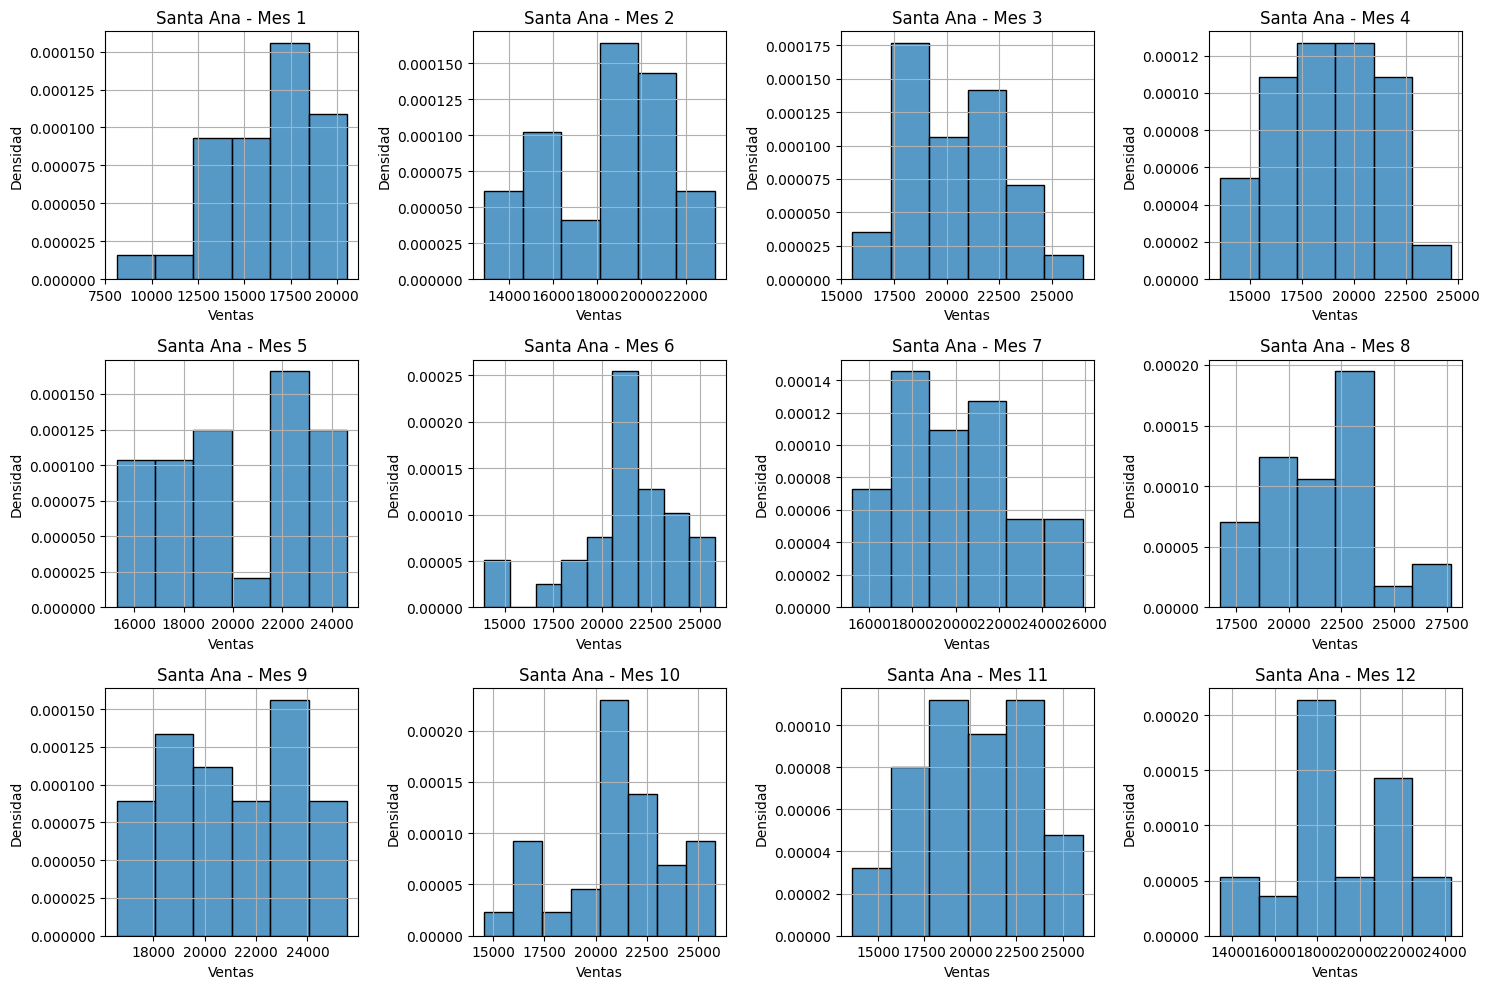

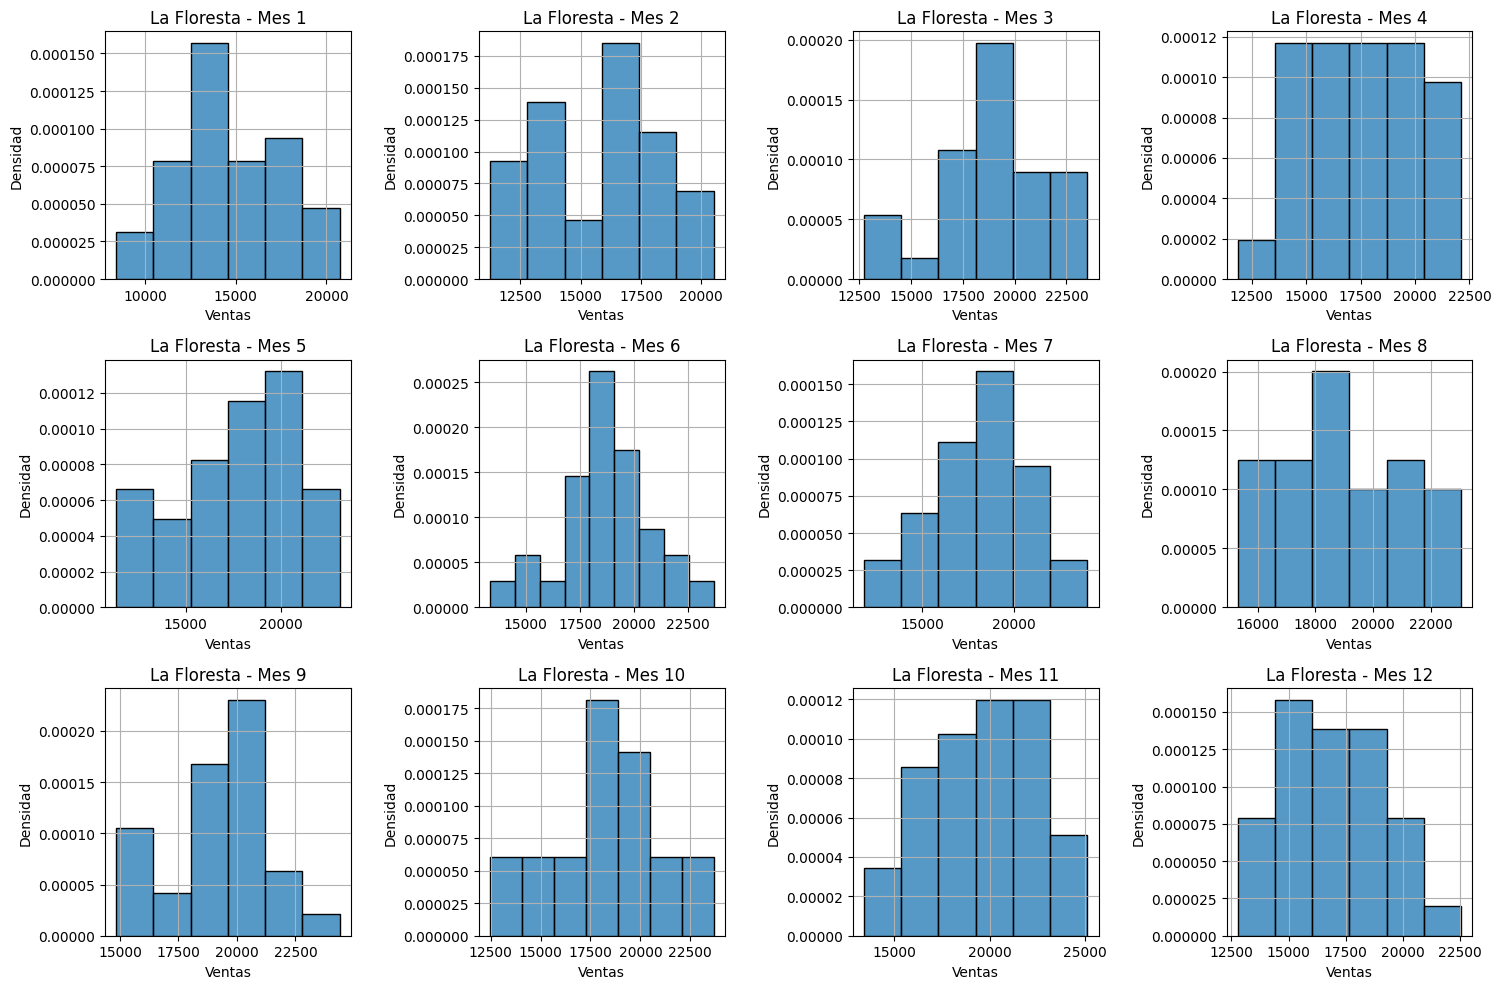

In [43]:
plot_densidad_por_mes(dfSantaAna, 'Santa Ana')
plot_densidad_por_mes(dfLaFloresta, 'La Floresta')  

In [ ]:

import numpy as np
from scipy.stats import t

# Tus datos (ejemplo)
ventas_mes = np.array([...])
n = len(ventas_mes)
media = np.mean(ventas_mes)
desv = np.std(ventas_mes, ddof=1)

# Intervalo de confianza al 95%
alpha = 0.05
t_crit_95 = t.ppf(1 - alpha/2, df=n-1)
margen_error_95 = t_crit_95 * (desv / np.sqrt(n))
ic_95 = (media - margen_error_95, media + margen_error_95)

# Intervalo de confianza al 99%
alpha = 0.01
t_crit_99 = t.ppf(1 - alpha/2, df=n-1)
margen_error_99 = t_crit_99 * (desv / np.s

In [58]:
def plot_tsudent_por_mes(df, tienda):
    meses = df['mes'].unique()
    meses = sorted(meses)

    for i, mes in enumerate(meses, 1):
        ventas_mes = df[df['mes'] == mes]['Ventas'].dropna()
        n = len(ventas_mes)
        media = np.mean(ventas_mes)
        desv = np.std(ventas_mes, ddof=1)
        # Intervalo de confianza al 95%
        alpha = 0.05
        t_crit_95 = t.ppf(1 - alpha/2, df=n-1)
        margen_error_95 = t_crit_95 * (desv / np.sqrt(n))
        ic_95 = (media - margen_error_95, media + margen_error_95)
        print(f"Intervalo de confianza al 95% para {tienda} - Mes {mes}: {ic_95}")
        # Intervalo de confianza al 99%
        alpha = 0.01
        t_crit_99 = t.ppf(1 - alpha/2, df=n-1)
        margen_error_99 = t_crit_99 * (desv / np.sqrt(n))
        ic_99 = (media - margen_error_99, media + margen_error_99)
        print(f"Intervalo de confianza al 99% para {tienda} - Mes {mes}: {ic_99}")

In [59]:
plot_tsudent_por_mes(dfSantaAna, 'Santa Ana')

Intervalo de confianza al 95% para Santa Ana - Mes 1: (np.float64(15049.02470569485), np.float64(17196.774008720196))
Intervalo de confianza al 99% para Santa Ana - Mes 1: (np.float64(14676.887286181449), np.float64(17568.911428233598))
Intervalo de confianza al 95% para Santa Ana - Mes 2: (np.float64(17546.930739563802), np.float64(19751.396272894963))
Intervalo de confianza al 99% para Santa Ana - Mes 2: (np.float64(17160.76691749937), np.float64(20137.560094959394))
Intervalo de confianza al 95% para Santa Ana - Mes 3: (np.float64(19372.550914425905), np.float64(21205.075996478663))
Intervalo de confianza al 99% para Santa Ana - Mes 3: (np.float64(19055.031940368695), np.float64(21522.594970535873))
Intervalo de confianza al 95% para Santa Ana - Mes 4: (np.float64(17806.619944176855), np.float64(19738.86319101556))
Intervalo de confianza al 99% para Santa Ana - Mes 4: (np.float64(17470.68532453917), np.float64(20074.797810653246))
Intervalo de confianza al 95% para Santa Ana - Mes 5